In [1]:
import pandas as pd
from google.colab import drive
from pathlib import Path
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
ml4t_folder = Path('/content/drive/My Drive/ML4T')
source_file = ml4t_folder / 'itch.h5'
data_path = Path('/content/data')
itch_store = data_path / 'itch.h5'

# Create the data folder if it doesn't exist
data_path.mkdir(parents=True, exist_ok=True)

# Check if the file exists in Google Drive
if not source_file.exists():
    raise FileNotFoundError(f"The file {source_file} does not exist in your Google Drive.")

# Copy the file from Google Drive to Colab
shutil.copy2(str(source_file), str(itch_store))
print(f"Copied {source_file} to {itch_store}")

def load_all_hdf_groups(file_path):
    """
    Load all groups from an HDF5 file into a dictionary.

    :param file_path: Path to the HDF5 file
    :return: A dictionary where keys are group names and values are DataFrames
    """
    data_dict = {}
    with pd.HDFStore(file_path, mode='r') as store:
        for key in store.keys():
            # Remove the leading '/' from the key
            group_name = key.lstrip('/')
            data_dict[group_name] = store.get(key)
            print(f"Loaded group: {group_name}")
    return data_dict

# Load all groups
all_data = load_all_hdf_groups(itch_store)

# Now you can access each group as a DataFrame
for group_name, df in all_data.items():
    print(f"\nGroup: {group_name}")
    print(f"Shape: {df.shape}")
    print("First few rows:")
    print(df.head())
    print("\n" + "="*50 + "\n")

# If you want to work with a specific group later
# For example, if you have a group named 'messages':
# messages_df = all_data['messages']

Mounted at /content/drive
Copied /content/drive/My Drive/ML4T/itch.h5 to /content/data/itch.h5
Loaded group: A
Loaded group: B
Loaded group: C
Loaded group: D
Loaded group: E
Loaded group: F
Loaded group: H
Loaded group: I
Loaded group: J
Loaded group: L
Loaded group: P
Loaded group: Q
Loaded group: R
Loaded group: S
Loaded group: U
Loaded group: V
Loaded group: X
Loaded group: Y
Loaded group: summary

Group: A
Shape: (127214649, 7)
First few rows:
   stock_locate  tracking_number                 timestamp  \
0          6963                0 0 days 04:00:00.001313761   
1          6963                0 0 days 04:00:00.001401480   
2          6963                0 0 days 04:00:00.001445278   
3          6963                0 0 days 04:00:00.001488348   
4          6537                0 0 days 04:00:00.002902396   

   order_reference_number  buy_sell_indicator  shares    price  
0                      11                   1    3400    71100  
1                      35                   

In [2]:
# Now you can access each group as a DataFrame and print column data types
for group_name, df in all_data.items():
    print(f"\nGroup: {group_name}")
    print(f"Shape: {df.shape}")
    print("Column data types:")
    for column, dtype in df.dtypes.items():
        print(f"  {column}: {dtype}")
    #print("\nFirst few rows:")
    #print(df.head())
    print("\n" + "="*50 + "\n")


Group: A
Shape: (127214649, 7)
Column data types:
  stock_locate: int64
  tracking_number: int64
  timestamp: timedelta64[ns]
  order_reference_number: int64
  buy_sell_indicator: int64
  shares: int64
  price: int64



Group: B
Shape: (1, 4)
Column data types:
  stock_locate: int64
  tracking_number: int64
  timestamp: timedelta64[ns]
  match_number: int64



Group: C
Shape: (129729, 8)
Column data types:
  stock_locate: int64
  tracking_number: int64
  timestamp: timedelta64[ns]
  order_reference_number: int64
  executed_shares: int64
  match_number: int64
  printable: object
  execution_price: int64



Group: D
Shape: (123296742, 4)
Column data types:
  stock_locate: int64
  tracking_number: int64
  timestamp: timedelta64[ns]
  order_reference_number: int64



Group: E
Shape: (7316703, 6)
Column data types:
  stock_locate: int64
  tracking_number: int64
  timestamp: timedelta64[ns]
  order_reference_number: int64
  executed_shares: int64
  match_number: int64



Group: F
Shape: (14

In [3]:
# Standard library imports
from pathlib import Path  # For handling file paths in a cross-platform way
from collections import Counter  # For counting occurrences of items
from datetime import timedelta, datetime  # For working with dates and times
from time import time  # For measuring execution time

# Third-party library imports
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Visualization libraries
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import matplotlib.patches as mpatches  # For adding shapes to plots
import seaborn as sns  # For statistical data visualization

# Set up seaborn style for better-looking plots
sns.set_style('whitegrid')

# Helper function to format time for display
def format_time(t):
    """Return a formatted time string 'HH:MM:SS'
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

# Set data paths
data_path = Path('data')  # Base path for data storage
itch_store = str(data_path / 'itch.h5')  # Path for storing parsed ITCH data
order_book_store = data_path / 'order_book.h5'  # Path for storing reconstructed order book data
date = '10302019'  # Date of the NASDAQ ITCH data sample

# These paths will be used to read and write data throughout the notebook.
# The .h5 extension indicates that we're using HDF5 file format, which is
# efficient for storing and reading large datasets.

# Define constants
stock = 'AAPL'  # The stock symbol we're focusing on
order_dict = {-1: 'sell', 1: 'buy'}  # Dictionary to map order types to strings

# This setup allows us to easily switch between different stocks and dates
# by changing these variables, making the code more flexible and reusable.

In [6]:
def get_messages(date, stock=stock):
    """Collect trading messages for a given stock on a specific date.

    This function retrieves and processes various types of trading messages
    from the ITCH data store for a particular stock.

    Parameters:
    date (str): The date of the trading data in 'MMDDYYYY' format.
    stock (str): The stock symbol, defaults to the global 'stock' variable.

    Returns:
    pd.DataFrame: A DataFrame containing all relevant trading messages for the stock.
    """
    with pd.HDFStore(itch_store) as store:
        # Get the stock_locate code for the specified stock
        stock_locate = store.select('R', where='stock = stock').stock_locate.iloc[0]
        target = 'stock_locate = stock_locate'

        # Initialize a dictionary to store different types of messages
        data = {}

        # List of message types we're interested in
        messages = ['A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q']

        # Retrieve each message type from the store
        for m in messages:
            data[m] = (store.select(m, where=target)
                       .drop('stock_locate', axis=1)
                       .assign(type=m))

    # Combine add order messages (A and F)
    order_cols = ['order_reference_number', 'buy_sell_indicator', 'shares', 'price']
    orders = pd.concat([data['A'], data['F']], sort=False, ignore_index=True).loc[:, order_cols]

    # Merge order information into other message types
    for m in messages[2:-3]:  # E, C, X, D, U
        data[m] = data[m].merge(orders, how='left')

    # Special handling for replace messages (U)
    data['U'] = data['U'].merge(orders,
                                how='left',
                                right_on='order_reference_number',
                                left_on='original_order_reference_number',
                                suffixes=['', '_replaced'])

    # Rename columns for consistency
    data['Q'].rename(columns={'cross_price': 'price'}, inplace=True)
    data['X']['shares'] = data['X']['cancelled_shares']

    # Remove rows with missing price (likely irrelevant for analysis)
    data['X'] = data['X'].dropna(subset=['price'])

    # Combine all message types into a single DataFrame
    data = pd.concat([data[m] for m in messages], ignore_index=True, sort=False)

    # Convert date string to datetime and add to timestamp
    data['date'] = pd.to_datetime(date, format='%m%d%Y')
    data.timestamp = data['date'].add(data.timestamp)

    # Filter out non-printable messages
    data = data[data.printable != 0]

    # Remove unnecessary columns
    drop_cols = ['tracking_number', 'order_reference_number', 'original_order_reference_number',
                 'cross_type', 'new_order_reference_number', 'attribution', 'match_number',
                 'printable', 'date', 'cancelled_shares']

    # Return the cleaned and sorted DataFrame
    return data.drop(drop_cols, axis=1).sort_values('timestamp').reset_index(drop=True)

In [7]:
# Retrieve messages for the specified date and stock
messages = get_messages(date=date)

# Display information about the resulting DataFrame
print(messages.info())
print("\nNull counts:")
print(messages.isnull().sum())

# Store the messages in the order book HDF5 store
with pd.HDFStore(order_book_store) as store:
    key = f'{stock}/messages'
    store.put(key, messages)
    print(store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813997 entries, 0 to 813996
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           813997 non-null  datetime64[ns]
 1   buy_sell_indicator  755911 non-null  float64       
 2   shares              808721 non-null  float64       
 3   price               808721 non-null  float64       
 4   type                813997 non-null  object        
 5   executed_shares     54584 non-null   float64       
 6   execution_price     373 non-null     float64       
 7   shares_replaced     4886 non-null    float64       
 8   price_replaced      4886 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 55.9+ MB
None

Null counts:
timestamp                  0
buy_sell_indicator     58086
shares                  5276
price                   5276
type                       0
executed_shares       75941

In [8]:
def get_trades(m):
    """
    Combine C, E, P and Q messages into trading records.

    Parameters:
    m (pd.DataFrame): DataFrame containing all messages

    Returns:
    pd.DataFrame: A DataFrame of trades with timestamp index and columns for price, shares, and cross
    """
    # Dictionary to standardize column names
    trade_dict = {'executed_shares': 'shares', 'execution_price': 'price'}

    # Columns we want to extract from the messages
    cols = ['timestamp', 'executed_shares']

    # Combine different types of trade messages
    trades = pd.concat([
        # Type E (Order executed message)
        m.loc[m.type == 'E', cols + ['price']].rename(columns=trade_dict),

        # Type C (Order executed with price message)
        m.loc[m.type == 'C', cols + ['execution_price']].rename(columns=trade_dict),

        # Type P (Trade message, non-cross)
        m.loc[m.type == 'P', ['timestamp', 'price', 'shares']],

        # Type Q (Cross trade message)
        m.loc[m.type == 'Q', ['timestamp', 'price', 'shares']].assign(cross=1)
    ], sort=False)

    # Remove any trades with NaN prices and fill NaN values in other columns
    trades = trades.dropna(subset=['price']).fillna(0)

    # Set the timestamp as the index, sort, and convert to integers
    return trades.set_index('timestamp').sort_index().astype(int)

# Apply the get_trades function to our messages
trades = get_trades(messages)

# Display information about the resulting trades DataFrame
print(trades.info())

# Store the trades data in the HDF5 file
with pd.HDFStore(order_book_store) as store:
    store.put(f'{stock}/trades', trades)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72017 entries, 2019-10-30 04:00:02.486519868 to 2019-10-30 19:59:59.248635671
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   shares  72017 non-null  int64
 1   price   72017 non-null  int64
 2   cross   72017 non-null  int64
dtypes: int64(3)
memory usage: 2.2 MB
None


In [9]:
# Define the number of price levels we want to track in the order book
nlevels = 100

def add_orders(orders, buysell, nlevels):
    """
    Add orders up to desired depth given by nlevels.
    Sell orders are sorted in ascending order, buy orders in descending order.
    """
    # Initialize an empty list to store the new orders
    new_order = []
    # Create a sorted list of (price, shares) tuples from the orders Counter
    items = sorted(orders.copy().items())
    # If it's a buy order, reverse the list (descending order)
    if buysell == 1:
        items = reversed(items)
    # Iterate through the sorted items
    for i, (p, s) in enumerate(items, 1):
        # Add the (price, shares) tuple to the new_order list
        new_order.append((p, s))
        # If we've reached the desired number of levels, stop
        if i == nlevels:
            break
    # Return the original orders Counter and the new_order list
    return orders, new_order

def save_orders(orders, append=False):
    """
    Save the current state of the order book to HDF5 storage.
    """
    # Define the columns for our DataFrame
    cols = ['price', 'shares']
    # Iterate over buy and sell orders
    for buysell, book in orders.items():
        # Create a DataFrame from the order book data
        df = pd.concat([
            pd.DataFrame(data=data, columns=cols).assign(timestamp=t)
            for t, data in book.items()
        ])
        # Create the key for the HDF5 store
        key = f'{stock}/{order_dict[buysell]}'
        # Convert price and shares columns to integers
        df.loc[:, ['price', 'shares']] = df.loc[:, ['price', 'shares']].astype(int)
        # Open the HDF5 store and save the data
        with pd.HDFStore(order_book_store) as store:
            if append:
                # If appending, use the append method with table format
                store.append(key, df.set_index('timestamp'), format='t')
            else:
                # If not appending, use the put method
                store.put(key, df.set_index('timestamp'))

# Initialize data structures
order_book = {-1: {}, 1: {}}  # -1 for sell, 1 for buy
current_orders = {-1: Counter(), 1: Counter()}
message_counter = Counter()

# Start timing the process
start = time()

# Iterate through each message in the messages DataFrame
for message in messages.itertuples():
    # Get the index of the current message
    i = message[0]
    # Every 100,000 messages, print progress and save current state
    if i % 1e5 == 0 and i > 0:
        print(f'{i:,.0f}\t\t{format_time(time() - start)}')
        save_orders(order_book, append=True)
        order_book = {-1: {}, 1: {}}
        start = time()

    # Skip messages without a buy/sell indicator
    if np.isnan(message.buy_sell_indicator):
        continue

    # Update the message type counter
    message_counter.update(message.type)
    # Get the buy/sell indicator
    buysell = message.buy_sell_indicator
    # Initialize price and shares
    price, shares = None, None

    # Handle add or replace order messages
    if message.type in ['A', 'F', 'U']:
        price = int(message.price)
        shares = int(message.shares)

        # Update the current orders
        current_orders[buysell].update({price: shares})
        # Recalculate the order book
        current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
        # Add the new order to the order book
        order_book[buysell][message.timestamp] = new_order

    # Handle execute, cancel, or replace order messages
    if message.type in ['E', 'C', 'X', 'D', 'U']:
        if message.type == 'U':
            # For replace messages, use the replaced price and shares
            if not np.isnan(message.shares_replaced):
                price = int(message.price_replaced)
                shares = -int(message.shares_replaced)
        else:
            # For other messages, use the regular price and shares
            if not np.isnan(message.price):
                price = int(message.price)
                shares = -int(message.shares)

        if price is not None:
            # Update the current orders
            current_orders[buysell].update({price: shares})
            # If shares at this price level are now 0 or negative, remove the price level
            if current_orders[buysell][price] <= 0:
                current_orders[buysell].pop(price)
            # Recalculate the order book
            current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
            # Add the new order to the order book
            order_book[buysell][message.timestamp] = new_order

# Print message type counts
message_counter = pd.Series(message_counter)
print(message_counter)

# Save final state of order book
save_orders(order_book, append=True)

# Print information about the HDF5 store
with pd.HDFStore(order_book_store) as store:
    print(store.info())

100,000		00:00:35
200,000		00:00:52
300,000		00:00:51
400,000		00:00:56
500,000		00:00:54
600,000		00:00:56
700,000		00:01:05
800,000		00:00:50
A    357225
E     52781
D    318295
P     18861
X       576
F      2928
U      4886
C       359
dtype: int64
<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/buy                 frame_table  (typ->appendable,nrows->38081056,ncols->2,indexers->[index],dc->[])
/AAPL/messages            frame        (shape->[813997,9])                                                
/AAPL/sell                frame_table  (typ->appendable,nrows->31330569,ncols->2,indexers->[index],dc->[])
/AAPL/trades              frame        (shape->[72017,3])                                                 


                buy          sell
count  3.808096e+07  3.133057e+07
mean   2.437071e+02  2.495297e+02
std    1.994895e+00  1.126830e+03
min    1.000000e-02  2.412500e+02
1%     2.425800e+02  2.414600e+02
2%     2.427700e+02  2.416300e+02
10%    2.430600e+02  2.421100e+02
25%    2.432700e+02  2.425500e+02
50%    2.436100e+02  2.430200e+02
75%    2.440700e+02  2.436000e+02
90%    2.448800e+02  2.441900e+02
98%    2.451700e+02  2.455000e+02
99%    2.455900e+02  2.462800e+02
max    2.524400e+02  2.000000e+05


<ipython-input-11-56afeef846e3>:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(buy[buy.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price,
<ipython-input-11-56afeef846e3>:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sell[sell.price.between(240, 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39100 entries, 0 to 39099
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  39100 non-null  int64  
 1   price      39100 non-null  float64
 2   shares     39100 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 916.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39100 entries, 0 to 39099
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  39100 non-null  int64  
 1   price      39100 non-null  float64
 2   shares     39100 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 916.5 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 1572442200000000000 to 1572465540000000000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   390 non-null    float64
 1   shares  390 non-null 

<ipython-input-11-56afeef846e3>:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)


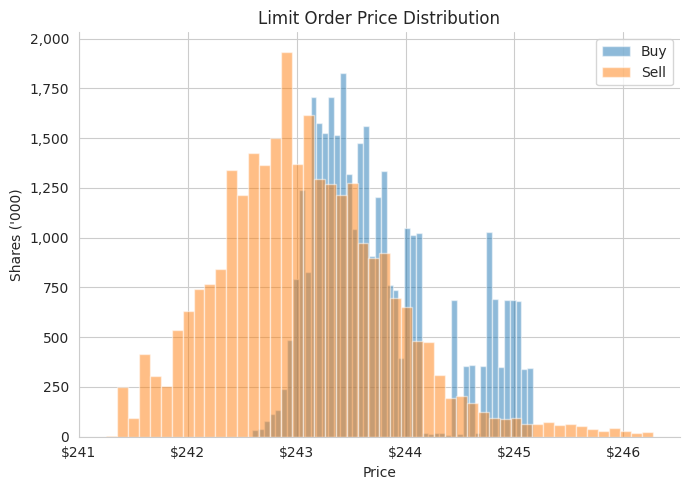

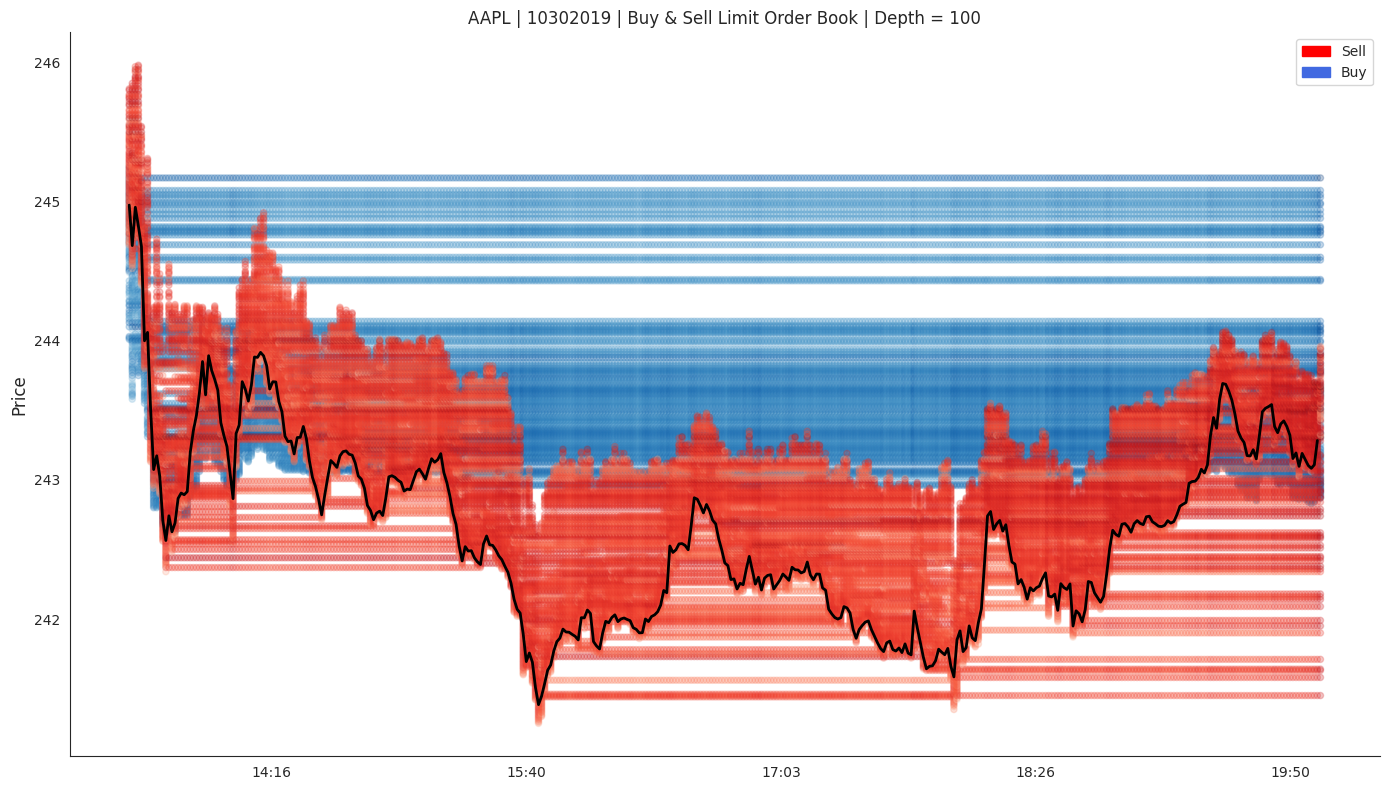

In [11]:
# Load the buy and sell order data from the HDF5 store
with pd.HDFStore(order_book_store) as store:
    buy = store[f'{stock}/buy'].reset_index().drop_duplicates()
    sell = store[f'{stock}/sell'].reset_index().drop_duplicates()

# Convert price to decimals (from integer representation)
buy.price = buy.price.mul(1e-4)
sell.price = sell.price.mul(1e-4)

# Calculate and display summary statistics for buy and sell prices
percentiles = [.01, .02, .1, .25, .75, .9, .98, .99]
price_summary = pd.concat([
    buy.price.describe(percentiles=percentiles).to_frame('buy'),
    sell.price.describe(percentiles=percentiles).to_frame('sell')
], axis=1)
print(price_summary)

# Remove outliers
buy = buy[buy.price > buy.price.quantile(.01)]
sell = sell[sell.price < sell.price.quantile(.99)]

# Define market open and close times
market_open='0930'
market_close = '1600'

# Buy-Sell Order Distribution
fig, ax = plt.subplots(figsize=(7,5))
hist_kws = {'linewidth': 1, 'alpha': .5}
sns.distplot(buy[buy.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price,
             ax=ax, label='Buy', kde=False, hist_kws=hist_kws)
sns.distplot(sell[sell.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price,
             ax=ax, label='Sell', kde=False, hist_kws=hist_kws)

ax.legend(fontsize=10)
ax.set_title('Limit Order Price Distribution')
ax.set_yticklabels([f'{int(y/1000):,}' for y in ax.get_yticks().tolist()])
ax.set_xticklabels([f'${int(x):,}' for x in ax.get_xticks().tolist()])
ax.set_xlabel('Price')
ax.set_ylabel("Shares ('000)")  # Corrected this line
sns.despine()
fig.tight_layout()

# Set the depth of the order book we want to analyze and UTC offset
depth = 100
utc_offset = timedelta(hours=4)

# Process buy orders
buy_per_min = (buy
    .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
    .shares.sum()
    .apply(np.log)
    .to_frame('shares')
    .reset_index('price')
    .between_time(market_open, market_close)
    .groupby(level='timestamp', as_index=False, group_keys=False)
    .apply(lambda x: x.nlargest(columns='price', n=depth))
    .reset_index())

buy_per_min.timestamp = buy_per_min.timestamp.add(utc_offset).astype(int)
print(buy_per_min.info())

# Process sell orders
sell_per_min = (sell
    .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
    .shares.sum()
    .apply(np.log)
    .to_frame('shares')
    .reset_index('price')
    .between_time(market_open, market_close)
    .groupby(level='timestamp', as_index=False, group_keys=False)
    .apply(lambda x: x.nsmallest(columns='price', n=depth))
    .reset_index())

sell_per_min.timestamp = sell_per_min.timestamp.add(utc_offset).astype(int)
print(sell_per_min.info())

# Load and process trade data
with pd.HDFStore(order_book_store) as store:
    trades = store[f'{stock}/trades']

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0].between_time(market_open, market_close)

trades_per_min = (trades
    .resample('Min')
    .agg({'price': 'mean', 'shares': 'sum'}))

trades_per_min.index = trades_per_min.index.to_series().add(utc_offset).astype(int)
print(trades_per_min.info())

# Order Book Depth Visualization
sns.set_style('white')
fig, ax = plt.subplots(figsize=(14, 6))

buy_per_min.plot.scatter(x='timestamp',
                         y='price',
                         c='shares',
                         ax=ax,
                         colormap='Blues',
                         colorbar=False,
                         alpha=.25)

sell_per_min.plot.scatter(x='timestamp',
                          y='price',
                          c='shares',
                          ax=ax,
                          colormap='Reds',
                          colorbar=False,
                          alpha=.25)

title = f'AAPL | {date} | Buy & Sell Limit Order Book | Depth = {depth}'
trades_per_min.price.plot(figsize=(14, 8),
                          c='k',
                          ax=ax,
                          lw=2,
                          title=title)

xticks = [datetime.fromtimestamp(ts / 1e9).strftime('%H:%M') for ts in ax.get_xticks()]
ax.set_xticklabels(xticks)

ax.set_xlabel('')
ax.set_ylabel('Price', fontsize=12)

red_patch = mpatches.Patch(color='red', label='Sell')
blue_patch = mpatches.Patch(color='royalblue', label='Buy')

plt.legend(handles=[red_patch, blue_patch])
sns.despine()
fig.tight_layout()

Loading and Preprocessing Data

Summary Statistics:
                buy          sell
count  3.808096e+07  3.133057e+07
mean   2.437071e+02  2.495297e+02
std    1.994895e+00  1.126830e+03
min    1.000000e-02  2.412500e+02
1%     2.425800e+02  2.414600e+02
2%     2.427700e+02  2.416300e+02
10%    2.430600e+02  2.421100e+02
25%    2.432700e+02  2.425500e+02
50%    2.436100e+02  2.430200e+02
75%    2.440700e+02  2.436000e+02
90%    2.448800e+02  2.441900e+02
98%    2.451700e+02  2.455000e+02
99%    2.455900e+02  2.462800e+02
max    2.524400e+02  2.000000e+05

Buy-Sell Order Distribution


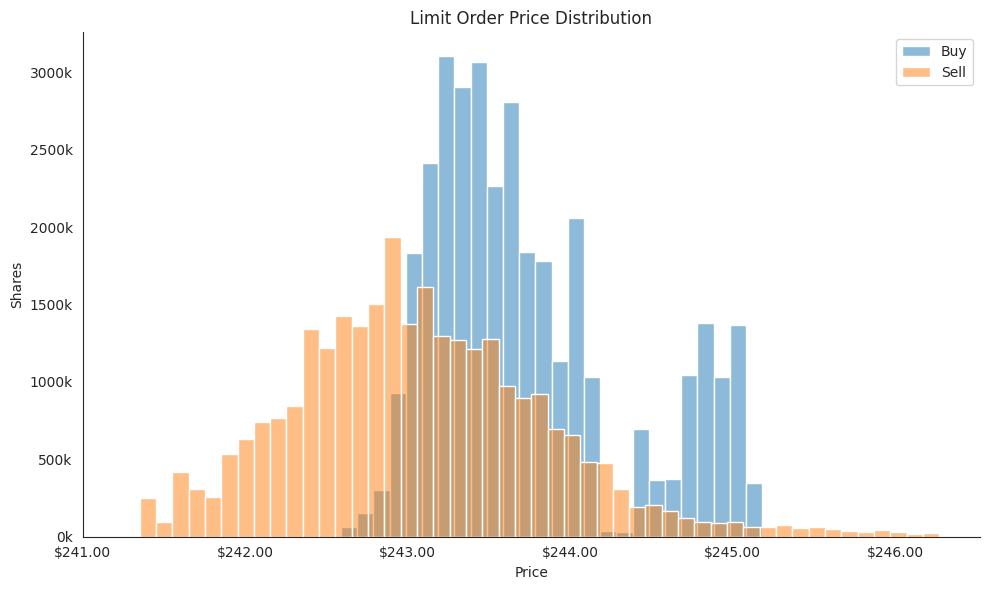


Processing Order Book Data

Buy orders info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39100 entries, 0 to 39099
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  39100 non-null  int64  
 1   price      39100 non-null  float64
 2   shares     39100 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 916.5 KB
None

Sell orders info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39100 entries, 0 to 39099
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  39100 non-null  int64  
 1   price      39100 non-null  float64
 2   shares     39100 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 916.5 KB
None

Trades info:
<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 1572442200000000000 to 1572465540000000000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------

<ipython-input-12-c78e9acecec0>:145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)


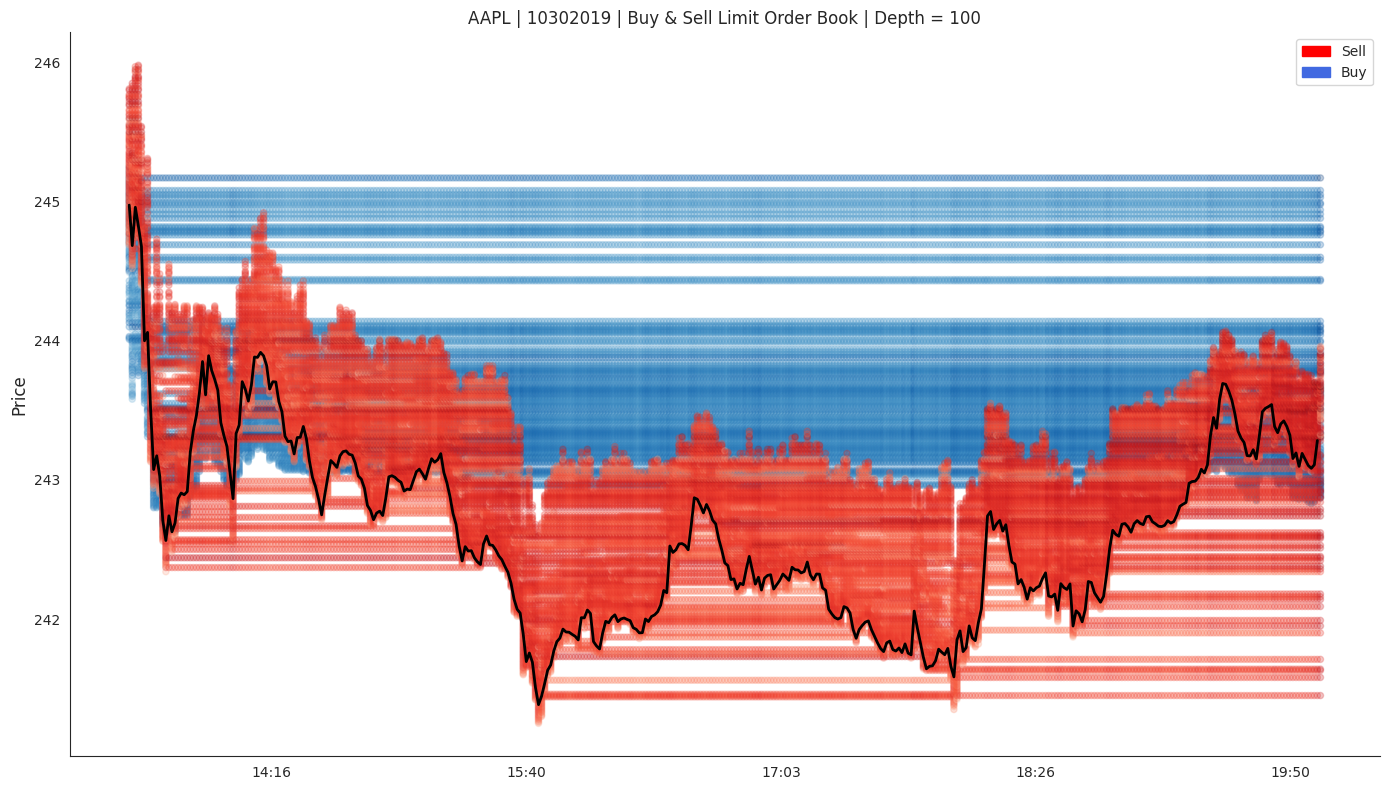

In [12]:
print("=" * 80)
print("Loading and Preprocessing Data")
print("=" * 80)

# Load the buy and sell order data from the HDF5 store
with pd.HDFStore(order_book_store) as store:
    buy = store[f'{stock}/buy'].reset_index().drop_duplicates()
    sell = store[f'{stock}/sell'].reset_index().drop_duplicates()

# Convert price to decimals (from integer representation)
buy.price = buy.price.mul(1e-4)
sell.price = sell.price.mul(1e-4)

print("\nSummary Statistics:")
# Calculate and display summary statistics for buy and sell prices
percentiles = [.01, .02, .1, .25, .75, .9, .98, .99]
price_summary = pd.concat([
    buy.price.describe(percentiles=percentiles).to_frame('buy'),
    sell.price.describe(percentiles=percentiles).to_frame('sell')
], axis=1)
print(price_summary)

# Remove outliers
buy = buy[buy.price > buy.price.quantile(.01)]
sell = sell[sell.price < sell.price.quantile(.99)]

# Define market open and close times
market_open='0930'
market_close = '1600'

print("\n" + "=" * 80)
print("Buy-Sell Order Distribution")
print("=" * 80)

# Buy-Sell Order Distribution
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(buy[buy.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price,
             ax=ax, label='Buy', kde=False, alpha=0.5, binwidth=0.1)
sns.histplot(sell[sell.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price,
             ax=ax, label='Sell', kde=False, alpha=0.5, binwidth=0.1)

ax.legend(fontsize=10)
ax.set_title('Limit Order Price Distribution')
ax.set_xlabel('Price')
ax.set_ylabel("Shares")

# Format x-axis labels as currency
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

# Format y-axis labels as thousands
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k'))

sns.despine()
fig.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("Processing Order Book Data")
print("=" * 80)

# Set the depth of the order book we want to analyze and UTC offset
depth = 100
utc_offset = timedelta(hours=4)

# Process buy orders
buy_per_min = (buy
    .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
    .shares.sum()
    .apply(np.log)
    .to_frame('shares')
    .reset_index('price')
    .between_time(market_open, market_close)
    .groupby(level='timestamp', as_index=False, group_keys=False)
    .apply(lambda x: x.nlargest(columns='price', n=depth))
    .reset_index())

buy_per_min.timestamp = buy_per_min.timestamp.add(utc_offset).astype(int)
print("\nBuy orders info:")
print(buy_per_min.info())

# Process sell orders
sell_per_min = (sell
    .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
    .shares.sum()
    .apply(np.log)
    .to_frame('shares')
    .reset_index('price')
    .between_time(market_open, market_close)
    .groupby(level='timestamp', as_index=False, group_keys=False)
    .apply(lambda x: x.nsmallest(columns='price', n=depth))
    .reset_index())

sell_per_min.timestamp = sell_per_min.timestamp.add(utc_offset).astype(int)
print("\nSell orders info:")
print(sell_per_min.info())

# Load and process trade data
with pd.HDFStore(order_book_store) as store:
    trades = store[f'{stock}/trades']

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0].between_time(market_open, market_close)

trades_per_min = (trades
    .resample('Min')
    .agg({'price': 'mean', 'shares': 'sum'}))

trades_per_min.index = trades_per_min.index.to_series().add(utc_offset).astype(int)
print("\nTrades info:")
print(trades_per_min.info())

print("\n" + "=" * 80)
print("Order Book Depth Visualization")
print("=" * 80)

# Order Book Depth Visualization
sns.set_style('white')
fig, ax = plt.subplots(figsize=(14, 6))

buy_per_min.plot.scatter(x='timestamp',
                         y='price',
                         c='shares',
                         ax=ax,
                         colormap='Blues',
                         colorbar=False,
                         alpha=.25)

sell_per_min.plot.scatter(x='timestamp',
                          y='price',
                          c='shares',
                          ax=ax,
                          colormap='Reds',
                          colorbar=False,
                          alpha=.25)

title = f'AAPL | {date} | Buy & Sell Limit Order Book | Depth = {depth}'
trades_per_min.price.plot(figsize=(14, 8),
                          c='k',
                          ax=ax,
                          lw=2,
                          title=title)

xticks = [datetime.fromtimestamp(ts / 1e9).strftime('%H:%M') for ts in ax.get_xticks()]
ax.set_xticklabels(xticks)

ax.set_xlabel('')
ax.set_ylabel('Price', fontsize=12)

red_patch = mpatches.Patch(color='red', label='Sell')
blue_patch = mpatches.Patch(color='royalblue', label='Buy')

plt.legend(handles=[red_patch, blue_patch])
sns.despine()
fig.tight_layout()
plt.show()

# Understanding the Limit Order Price Distribution Graph

## What the Graph Shows
- This is a snapshot of unfilled orders for one stock (likely AAPL).
- Orange bars represent sell orders.
- Blue bars represent buy orders.

## How Limit Orders Work
- Buy orders: "I want to buy if the price drops to this level or lower."
- Sell orders: "I want to sell if the price rises to this level or higher."

## Key Observations
1. Sell orders (orange) are grouped at lower prices.
2. Buy orders (blue) are spread out more, mostly at higher prices.
3. The current stock price is probably somewhere in the middle, where orange and blue meet.

## What This Means
- Sellers are ready to sell if the price goes up a little from the current price.
- Buyers have placed orders at various prices, mostly higher than where sellers are willing to sell.

## Why It Looks This Way
- Sellers seem to agree more on what price they want.
- Buyers have different ideas about what price is good to buy.

## Important Points to Remember
- These are not completed trades. They're just orders waiting to be filled.
- Actual trades happen when a buy price matches a sell price.

## Conclusion
This graph gives us insight into what prices buyers and sellers are hoping for, providing a glimpse into their perceptions of the stock's value. It's like seeing everyone's wishlist for this stock's price.

# Understanding the Buy & Sell Limit Order Book Graph

## What the Graph Shows
- This graph represents the limit order book for AAPL stock on 10/30/2019.
- It shows the depth of the market up to 100 price levels (Depth = 100).
- Red areas represent sell orders.
- Blue areas represent buy orders.
- The black line shows the actual trade price over time.

## Key Components
1. X-axis: Time of day (from about 14:16 to 19:50)
2. Y-axis: Price of AAPL stock (ranging from about $241 to $246)
3. Color intensity: Represents the volume of orders at each price point

## Key Observations
1. Order Book Structure:
   - Sell orders (red) are generally above the current price.
   - Buy orders (blue) are generally below the current price.
   - The gap between red and blue areas represents the bid-ask spread.

2. Price Movement:
   - The black line shows how the actual trade price fluctuates throughout the day.
   - The price generally moves within the areas of high order density.

3. Market Depth:
   - Dense color areas indicate high liquidity at those price levels.
   - Gaps or light areas suggest less liquidity.

4. Time Patterns:
   - The order book structure changes over time, with varying densities of buy and sell orders.
   - There are noticeable shifts in the order book around 15:40 and 18:26.

## What This Means
- This visualization gives a dynamic view of supply and demand for AAPL stock throughout the trading day.
- It shows how the market reacts and adjusts to price movements.
- Areas of dense color represent strong support (for buy orders) or resistance (for sell orders).

## Important Points to Remember
- This is a real-time representation of unfilled orders.
- The actual trades occur where the black line intersects the order book.
- The depth and structure of the order book can indicate market sentiment and potential future price movements.

## Conclusion
This graph provides a comprehensive view of market microstructure for AAPL stock, showing how buy and sell pressures evolve over time and how they relate to actual trade prices. It's a powerful tool for understanding market dynamics and liquidity at different price levels throughout the trading day.

In [14]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the base ML4T folder
ml4t_folder = '/content/drive/My Drive/ML4T'

# Define the source and destination paths
source_path = '/content/data/order_book.h5'
destination_path = os.path.join(ml4t_folder, 'order_book.h5')

# Create the destination directory if it doesn't exist
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# Copy the file
shutil.copy2(source_path, destination_path)

print(f"File copied from {source_path} to {destination_path}")

# Verify the file size
file_size = os.path.getsize(destination_path)
print(f"Size of copied file: {file_size / (1024 * 1024):.2f} MB")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File copied from /content/data/order_book.h5 to /content/drive/My Drive/ML4T/order_book.h5
Size of copied file: 1666.17 MB

Contents of ML4T/ directory:
order_book.h5: 1666.17 MB
